# Retirement Planner

---

## Environment Setup

In [2]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [3]:
# Set the random seed for results reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [4]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [6]:
# Display sample data
df.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [7]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()

# Display sample data
daily_returns.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844


In [8]:
# Use the `mean` function to calculate the mean of daily returns for `TLSA` and `SPHD`, respectively
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
print(f"The mean daily return of SPY is {avg_daily_return_spy}.")
print(f"The mean daily return of AGG is {avg_daily_return_agg}.")

The mean daily return of SPY is 0.0010401250682146959.
The mean daily return of AGG is 0.00021276976507473064.


In [9]:
# Compute daily volatility
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
print(f"The daily volatility of SPY is {std_dev_daily_return_spy}.")
print(f"The daily volatility of AGG is {std_dev_daily_return_agg}.")

The daily volatility of SPY is 0.007820053413439366.
The daily volatility of AGG is 0.0020886019741764646.


In [10]:
# Save the last day's closing price
last_close_spy = df['SPY']['close'][-1]
last_close_agg = df['AGG']['close'][-1]
print(f"The last closing price of SPY is {last_close_spy}.")
print(f"The last closing price of AGG is {last_close_agg}.")

The last closing price of SPY is 321.92.
The last closing price of AGG is 112.37.


In [11]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [12]:
# Run the Monte Carlo Simulation 500 times
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    simulated_spy_prices = [last_close_spy]
    simulated_agg_prices = [last_close_agg]
    
    # Simulate the returns for 252 * 30 days
    for i in range(number_records):

        # Calculate the simulated price using the last price within the list
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.4, 0.6]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

In [14]:
# Check that the simulation ran successfully
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001924,0.997505,0.995700,1.000705,1.005416,1.003571,1.005572,0.999815,1.001367,0.998857,...,1.001749,0.996288,1.004930,1.000495,0.998097,1.002516,0.997957,0.997280,1.001753,0.997615
2,1.006411,1.000684,0.996078,0.998851,1.007231,0.997945,1.001722,0.992297,1.000858,1.003898,...,1.003733,1.001281,1.007210,1.002168,0.999241,0.998881,0.997915,0.997455,1.001487,1.000715
3,1.005926,1.000743,0.998432,0.995538,1.006644,0.998970,1.004883,0.987721,1.000825,1.010425,...,1.004013,1.002157,1.010372,1.003880,0.994553,0.998616,1.001211,1.000151,1.004101,1.000766
4,1.012409,1.003035,0.997002,0.999986,1.008601,0.996445,1.004989,0.985181,1.006183,1.004915,...,1.004917,1.001715,1.009675,1.006305,0.998787,0.996727,0.997377,1.001179,1.006803,1.003199


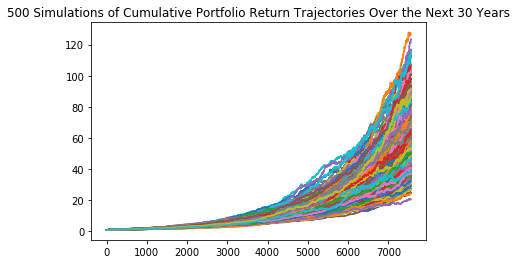

In [15]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [27]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns

0       63.797071
1       55.436929
2       68.111555
3       67.712711
4       66.032144
5       65.408500
6       58.953260
7       88.166348
8       67.588066
9       68.887380
10      43.608246
11      96.591540
12      52.163591
13      38.702798
14      58.766166
15      51.814541
16      44.239001
17      52.660175
18     105.756540
19      49.379916
20      24.719835
21      76.421248
22      47.551214
23      80.190799
24      68.245131
25      88.994045
26      34.217554
27      45.910933
28      58.293079
29      50.562370
          ...    
470     50.382153
471     45.642490
472     50.182663
473     42.359872
474     47.530478
475     57.651346
476     40.640031
477     58.204103
478     48.682430
479     82.702149
480     59.802400
481     57.639197
482     34.975111
483     60.154736
484     44.232416
485     62.860663
486     76.830943
487     59.234688
488     52.907576
489     46.138907
490     32.336549
491     72.312955
492     50.222883
493     64.992550
494     78

In [35]:
ending_cumulative_returns.mean()

60.20306795824819

### Plot the Frequency Distribution of Simulated Ending Portfolio Cumulative Returns on the Last Trading Day

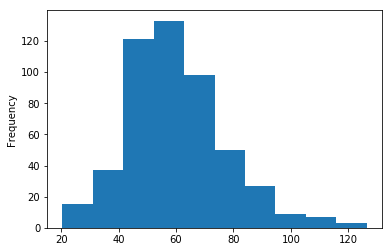

In [17]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
ending_cumulative_returns.plot(kind='hist', bins=10)

### Calculate the Probability Distribution of Ending Cumulative Return Ranges

In [18]:
# Use the `value_counts` function and the `len` function to calculate the probabilities of cumulative return ranges
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)

(52.233, 62.833]      0.266
(41.633, 52.233]      0.242
(62.833, 73.433]      0.196
(73.433, 84.033]      0.100
(31.033, 41.633]      0.074
(84.033, 94.633]      0.054
(20.326, 31.033]      0.030
(94.633, 105.233]     0.018
(105.233, 115.833]    0.014
(115.833, 126.433]    0.006
Name: 7560, dtype: float64

### Calculate Lower and Upper Bounds of 90% Confidence Interval for Simulated Ending Cumulative Portfolio Returns

In [19]:
# Use the `quantile` function to calculate the 90% confidence interval for simulated ending prices
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])

In [20]:
# Display the 90% confidence interval for the ending returns
confidence_interval

0.05    34.496951
0.95    92.235803
Name: 7560, dtype: float64

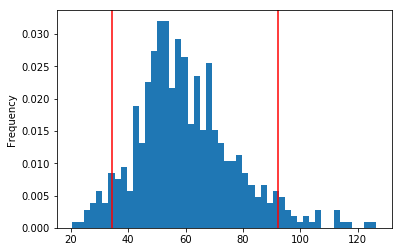

In [23]:
# Visualize the distribution of the ending returns

# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 90% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=50)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [24]:
# Compute cumulative returns
print(ending_cumulative_returns)

0       63.797071
1       55.436929
2       68.111555
3       67.712711
4       66.032144
5       65.408500
6       58.953260
7       88.166348
8       67.588066
9       68.887380
10      43.608246
11      96.591540
12      52.163591
13      38.702798
14      58.766166
15      51.814541
16      44.239001
17      52.660175
18     105.756540
19      49.379916
20      24.719835
21      76.421248
22      47.551214
23      80.190799
24      68.245131
25      88.994045
26      34.217554
27      45.910933
28      58.293079
29      50.562370
          ...    
470     50.382153
471     45.642490
472     50.182663
473     42.359872
474     47.530478
475     57.651346
476     40.640031
477     58.204103
478     48.682430
479     82.702149
480     59.802400
481     57.639197
482     34.975111
483     60.154736
484     44.232416
485     62.860663
486     76.830943
487     59.234688
488     52.907576
489     46.138907
490     32.336549
491     72.312955
492     50.222883
493     64.992550
494     78

In [36]:
percentile10 = np.percentile(ending_cumulative_returns, 10)
percentile50 = np.percentile(ending_cumulative_returns, 50)
percentile90 = np.percentile(ending_cumulative_returns, 90)
print(f"The expected cumulative return for the 10th percentile is {percentile10:,.2f}.")
print(f"The expected cumulative return for the 50th percentile is {percentile50:,.2f}.")
print(f"The expected cumulative return for the 90th percentile is {percentile90:,.2f}.")

The expected cumulative return for the 10th percentile is 41.26.
The expected cumulative return for the 50th percentile is 57.74.
The expected cumulative return for the 90th percentile is 82.33.


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [30]:
# Set initial investment
initial_investment = 20000

# Compute expected portfolio return

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment * percentile10
investment_pnl_middle_bound = initial_investment * percentile50
investment_pnl_upper_bound = initial_investment * percentile90
                                                    
# Print the results
print(f"The expected portfolio return for the 10th percentile is ${investment_pnl_lower_bound:,.2f}.")
print(f"The expected portfolio return for the 50th percentile is ${investment_pnl_middle_bound:,.2f}.")
print(f"The expected portfolio return for the 90th percentile is ${investment_pnl_upper_bound:,.2f}.")

The expected portfolio return for the 10th percentile is $825,232.57.
The expected portfolio return for the 50th percentile is $1,154,758.94.
The expected portfolio return for the 90th percentile is $1,646,564.34.


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [31]:
# Set Plaid's projected income
plaid_projected_annual_income =  7389

# Calculate the 4% withdrawal for the ending return as retirement income
retirement_income = .04 * (initial_investment * percentile10)

# Determine if the retirement income meets or exceeds the current projected income
if retirement_income >= plaid_projected_annual_income:
    print(f"You will have ${retirement_income:,.2f} in retirement income which is sufficient.")
else:
    print(f"You will have ${retirement_income:,.2f} in retirement income which is not sufficient.")

You will have $33,009.30 in retirement income which is sufficient.


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [32]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
plaid_projected_annual_income =  7389

# Calculate the 4% withdrawal for the ending return as retirement income
retirement_income = .04 * (initial_investment* 1.5 * percentile10)

# Determine if the retirement income meets or exceeds the current projected income
if retirement_income >= plaid_projected_annual_income:
    print(f"You will have ${retirement_income:,.2f} in retirement income which is sufficient.")
else:
    print(f"You will have ${retirement_income:,.2f} in retirement income which is not sufficient.")

You will have $49,513.95 in retirement income which is sufficient.


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# Compute projected returns

# Display sample data


In [ ]:
# Plot the cumulative returns over time


In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
